In [1]:
#Bibliotecas

# Tratamento e análise
import pandas as pd
import numpy as np
import scipy.stats as stats

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Seleção
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV

# Pré-processamento
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Modelos de Classificação
from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# Modelo adicional de classificação:
# from sklearn.naive_bayes import GaussianNB
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Grid-Search
from sklearn.model_selection import GridSearchCV

# Métricas dos nossos modelos
from sklearn.metrics import accuracy_score, confusion_matrix 

## Classification Task
Esse Notebook é dedicado à tarefa de classificação dos dados obtidos em parte pelo repositório do Kaggle, parte pelo scraping feito no website "ZAP imóveis", o objetivo é classificar o preço de um imóvel. Diferentemente da tarefa de regressão onde tentamos classificar o valor do preço propriamente dito, aqui nós buscamos classificar de acordo com 3 categorias:


HIGH - Para imóveis considerados "caros" ou de alto valor.

MEDIUM - Para imóveis de valor não tão alto, valores médios.

LOW - Imóveis que possuem baixo preço

Não são especificados os limiares dessas classes, mas adianto que proponho 2 tipos

#### 1 - Classes iguais:

Nesse caso teríamos classes de tamanho igual. Dividindo os valores em 

HIGH -> Valores acima do percentil 66%

MEDIUM -> Valores entre os percentis de 33% e 66%

LOW -> Valores abaixo de 33%

#### 2 - Divisão por Quartis:

Aqui dividiriamos por quartil, de forma que:

HIGH -> Valores acima do terceiro quartil

MEDIUM -> Valores entre o primeiro quartil e o terceiro quartil

LOW -> Valores abaixo do primeiro quartil

Dependendo da escolha do modo que deve ser feito, essas classes podemos ter resultados relativamente diferentes.

### Análise dos Dados
Primeiramente vamos analisar algumas características dos dados para entender melhor o que fazer com cada um deles, inicialmente começaremos dando uma olhada geral nos dados. Procurando entender rapidamente um pouco sobre o que temos em mãos. Após a análise geral, o foco será na variável alvo, ver um pouco como está a distribuição e o que podemos fazer quanto a isso.

In [2]:
df = pd.read_csv("df_vendas_final.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16792 entries, 0 to 16791
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   bathrooms        16792 non-null  int64 
 1   parkingSpaces    16792 non-null  int64 
 2   suites           16792 non-null  int64 
 3   monthlyCondoFee  16792 non-null  int64 
 4   usableAreas      16792 non-null  int64 
 5   bedrooms         16792 non-null  int64 
 6   backyard         16792 non-null  int64 
 7   barbgrill        16792 non-null  int64 
 8   bathtub          16792 non-null  int64 
 9   fireplace        16792 non-null  int64 
 10  furnished        16792 non-null  int64 
 11  garden           16792 non-null  int64 
 12  guestpark        16792 non-null  int64 
 13  gym              16792 non-null  int64 
 14  hottub           16792 non-null  int64 
 15  partyhall        16792 non-null  int64 
 16  playground       16792 non-null  int64 
 17  pool             16792 non-null

Primeiro passo é transformar o salePrice, nossa variável alvo em categórico, mas para isso precisamos analisar melhor sua distribuição:

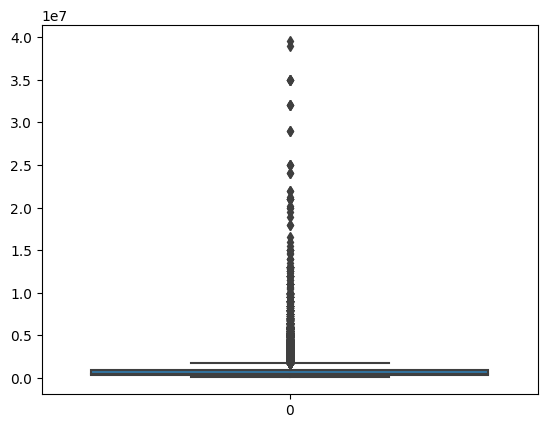

In [3]:
prices = df['salePrice']

sns.boxplot(data = prices)

# Exibindo o gráfico
plt.show()

Olhando de forma rápida, é fácil ver que a variável alvo possui inúmeros valores outliers, que podem ser retirados para facilitar a compreensão dos dados.

No entanto como utilizamos os quartis como critério, medidas robustas, para a criação das classes, não é tão nocivo assim manter esses outliers, pois no fim tratam-se apenas da classe "HIGH". Assim, não sendo tão nocivos quanto aparentam para nosso modelo de classificação, manterei os outliers pois eles serão de certa forma, "suavizados" quando aplicarmos as transformações.

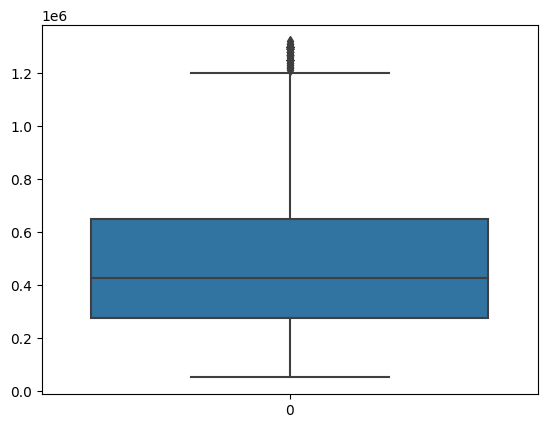

In [4]:
limit = prices.quantile(0.75) * 1.5 # retirando outliers
prices = prices[prices < limit]
# Checar a distribuição do salePrice após retirada
sns.boxplot(data = prices)

# Exibindo o gráfico
plt.show()
# Checando o gráfico dos salePrice sem os outliers

In [5]:
indices = prices.index

df_no_outlier = df.iloc[indices]

df_no_outlier.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13830 entries, 0 to 16791
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   bathrooms        13830 non-null  int64 
 1   parkingSpaces    13830 non-null  int64 
 2   suites           13830 non-null  int64 
 3   monthlyCondoFee  13830 non-null  int64 
 4   usableAreas      13830 non-null  int64 
 5   bedrooms         13830 non-null  int64 
 6   backyard         13830 non-null  int64 
 7   barbgrill        13830 non-null  int64 
 8   bathtub          13830 non-null  int64 
 9   fireplace        13830 non-null  int64 
 10  furnished        13830 non-null  int64 
 11  garden           13830 non-null  int64 
 12  guestpark        13830 non-null  int64 
 13  gym              13830 non-null  int64 
 14  hottub           13830 non-null  int64 
 15  partyhall        13830 non-null  int64 
 16  playground       13830 non-null  int64 
 17  pool             13830 non-null  int

Retirando os valores discrepantes perdemos uma quantidade considerável de linhas, indo de 16792 para 13129. 

Decidimos manter os outliers devido a classificação, então manteremos os 16792 linhas originais.

In [6]:
# função que vai categorizar os valores numéricos
def categorizar_por_percent(data, primeiro_percentil, segundo_percentil):
    if data > primeiro_percentil:
        return "HIGH"
    elif data <= primeiro_percentil and data > segundo_percentil:
        return "MEDIUM"
    else:
        return "LOW"

In [7]:
df_categoric = df.copy()

# Aplicando a segunda categorização que falamos, utilizando os quartis

divisao = df['salePrice'].quantile(0.75)
divisao2 =  df['salePrice'].quantile(0.25) 

df_categoric['salePrice'] = df['salePrice'].apply(categorizar_por_percent, 
                                                             primeiro_percentil=divisao, segundo_percentil=divisao2)

print(df_categoric['salePrice'].value_counts()) # apenas para checar como ficou os valores
df_categoric.info()

salePrice
MEDIUM    8396
HIGH      4198
LOW       4198
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16792 entries, 0 to 16791
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   bathrooms        16792 non-null  int64 
 1   parkingSpaces    16792 non-null  int64 
 2   suites           16792 non-null  int64 
 3   monthlyCondoFee  16792 non-null  int64 
 4   usableAreas      16792 non-null  int64 
 5   bedrooms         16792 non-null  int64 
 6   backyard         16792 non-null  int64 
 7   barbgrill        16792 non-null  int64 
 8   bathtub          16792 non-null  int64 
 9   fireplace        16792 non-null  int64 
 10  furnished        16792 non-null  int64 
 11  garden           16792 non-null  int64 
 12  guestpark        16792 non-null  int64 
 13  gym              16792 non-null  int64 
 14  hottub           16792 non-null  int64 
 15  partyhall        16792 non-null  int64 


### Análise das Colunas de X

Aqui vamos iniciar a análise das variáveis independentes, buscando entender melhor sua distribuição e o que deve ser feito com cada uma delas.

In [8]:
colunas_numericas = ['bathrooms', 'parkingSpaces', "suites",
                     'monthlyCondoFee', 'usableAreas', 'bedrooms']

# Primeiro capturamos os nomes das colunas que possuem valores numéricos, que não são apenas 1's e 0's

for coluna in colunas_numericas:
    print(coluna)
    print(df_categoric[coluna].value_counts().max())

# Checar se as colunas são majoritariamente dominadas por algum valor, 
# caso sejam talvez não seja tão vantajoso mantê-los

bathrooms
5771
parkingSpaces
8232
suites
10283
monthlyCondoFee
4004
usableAreas
386
bedrooms
6667


In [9]:
df_categoric = df_categoric.drop(['suites'], axis = 1) 
# Dropando suites devido a pouca informação trazida pois é altamente dominada por um valor

colunas_numericas.remove("suites") 
# Retirando a coluna suites dos nomes das colunas

Continuando a análise das colunas de X, aqui vamos plotar os gráficos das distribuições e um boxplot para entender um pouco sobre a possibilidade de Outliers e das medidas das colunas numéricas.

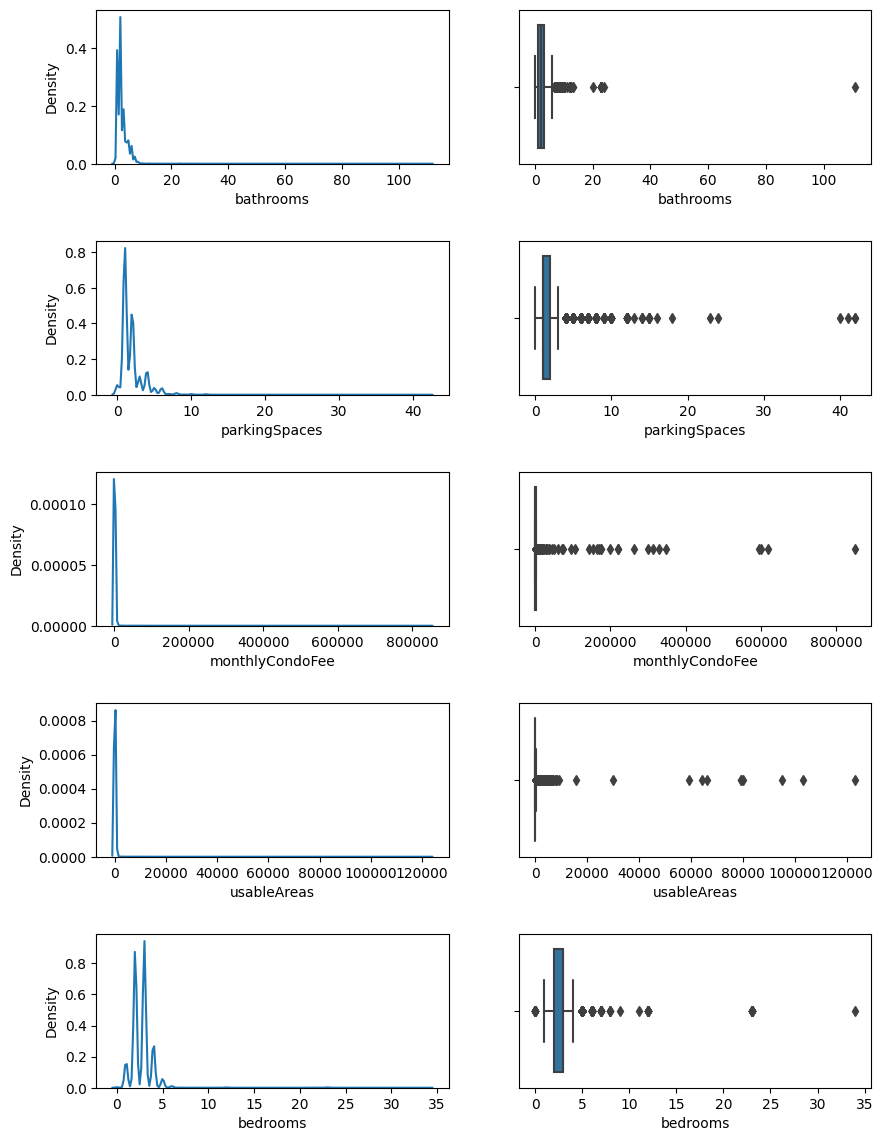

In [10]:
fig, ax = plt.subplots(len(colunas_numericas), 2, figsize=(10, 14))

for i, coluna in enumerate(colunas_numericas):
    
    sns.kdeplot(data=df_categoric, x=coluna, ax = ax[i][0])
    sns.boxplot(data=df_categoric, x=coluna, ax = ax[i][1])
    sns.set_style("whitegrid")
    
fig.subplots_adjust(hspace = 0.5)
plt.show()

A distribuição dos dados tem cauda alongada para direita e diversos outliers superiores, como esses valores se manterão numéricas, manter esses valores pode ser muito prejudicial para nossa classificação, dessa forma, retiramos esses valores do dataset. Não há necessidade de manter e modificar os dados pode piorar ainda mais a situação então retirar pode ser a melhor opção

In [11]:
def identificar_outliers(col):
    # Calcula os limites de outlier usando o método IQR
    Q1 = df_categoric[col].quantile(0.25)
    Q3 = df_categoric[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Retorna uma série booleana indicando se cada valor é um outlier
    return (df_categoric[col] < limite_inferior) | (df_categoric[col] > limite_superior)

In [12]:
# filtramos os outliers das colunas de X
df_filtrado = df_categoric.copy()
for col in colunas_numericas:
    df_filtrado = df_filtrado[~identificar_outliers(col)]

df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13611 entries, 0 to 16791
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   bathrooms        13611 non-null  int64 
 1   parkingSpaces    13611 non-null  int64 
 2   monthlyCondoFee  13611 non-null  int64 
 3   usableAreas      13611 non-null  int64 
 4   bedrooms         13611 non-null  int64 
 5   backyard         13611 non-null  int64 
 6   barbgrill        13611 non-null  int64 
 7   bathtub          13611 non-null  int64 
 8   fireplace        13611 non-null  int64 
 9   furnished        13611 non-null  int64 
 10  garden           13611 non-null  int64 
 11  guestpark        13611 non-null  int64 
 12  gym              13611 non-null  int64 
 13  hottub           13611 non-null  int64 
 14  partyhall        13611 non-null  int64 
 15  playground       13611 non-null  int64 
 16  pool             13611 non-null  int64 
 17  sauna            13611 non-null  int

/tmp/ipykernel_2443/3193774425.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtrado = df_filtrado[~identificar_outliers(col)]
/tmp/ipykernel_2443/3193774425.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtrado = df_filtrado[~identificar_outliers(col)]
/tmp/ipykernel_2443/3193774425.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtrado = df_filtrado[~identificar_outliers(col)]
/tmp/ipykernel_2443/3193774425.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtrado = df_filtrado[~identificar_outliers(col)]


Após a retirado dos outliers de todas essas colunas acabamos perdendo até que bastante linhas, mas mesmo assim temos uma quantidade de dados muito boa para treinarmos o modelo, seguimos a partir daqui com dados mais comportados e com bem menos valores discrepantes isso pode ser facilmente observado graficamente, como feito abaixo

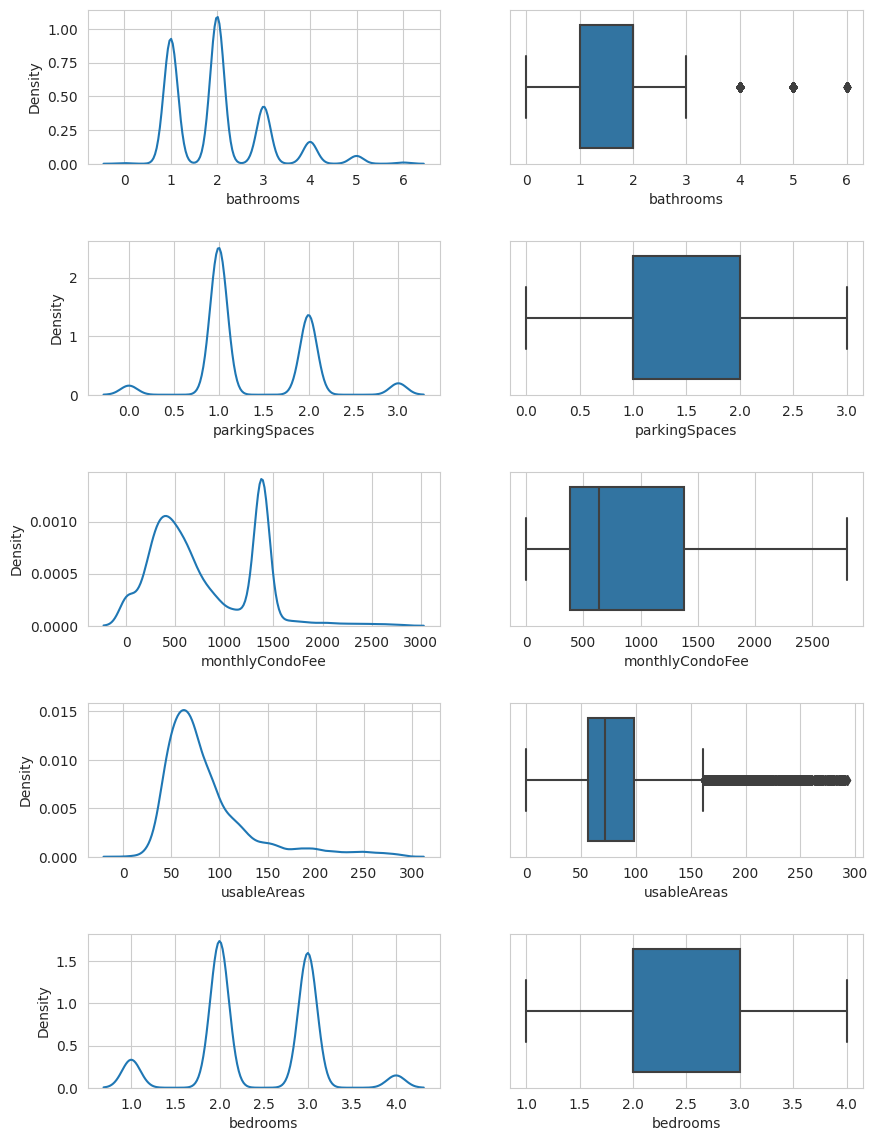

In [13]:
# Repetindo os gráficos feitos anteriormente
fig, ax = plt.subplots(len(colunas_numericas), 2, figsize=(10, 14))

for i, coluna in enumerate(colunas_numericas):
    
    sns.kdeplot(data=df_filtrado, x=coluna, ax = ax[i][0])
    sns.boxplot(data=df_filtrado, x=coluna, ax = ax[i][1])
    sns.set_style("whitegrid")
    
fig.subplots_adjust(hspace = 0.5)
plt.show()

Agora faremos uma melhor análise das variáveis categórias que possuimos, seja elas binárias ou multicategóricas.

In [14]:
colunas_categoricas_bool = \
                      ['backyard', 'barbgrill', 'bathtub',
                       'fireplace', 'furnished', 'garden',
                       'guestpark', 'gym', 'hottub',
                       'partyhall', 'playground', 'pool',
                       'sauna', 'sportcourt', 'tenniscourt']

colunas_multcategoricas = ['imvl_type', 'address.region']

Irei repetir mais ou menos o que fiz para variáveis numéricas, basicamente quando temos alguma variável booleana que muitos valores delas são de um valor, essa variável pode não trazer tanta informação quanto aparenta, dessa forma irei retirar as categóricas que forem altamente dominadas por um valor

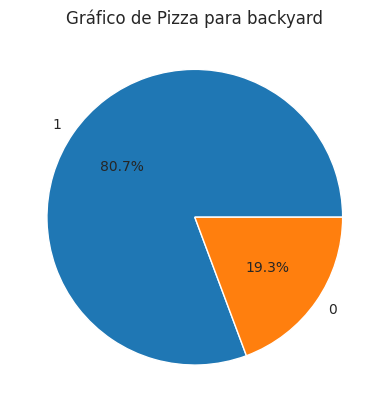

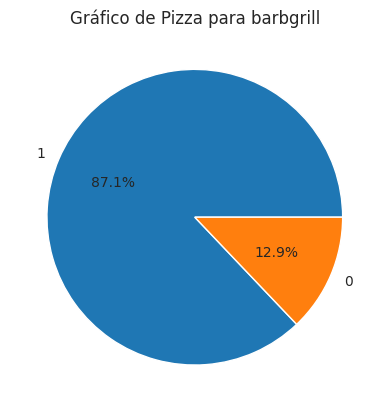

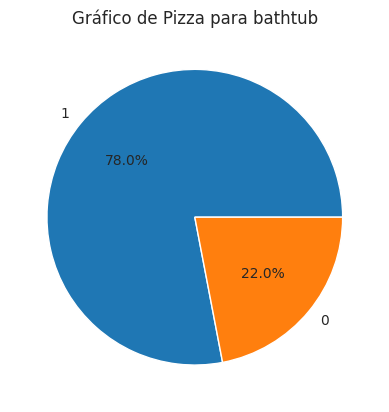

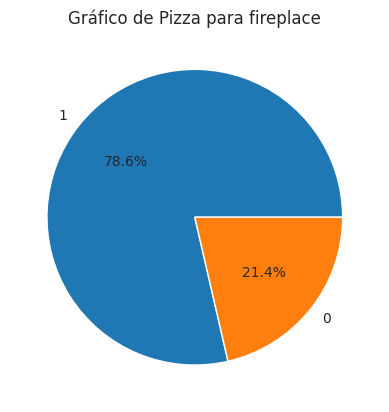

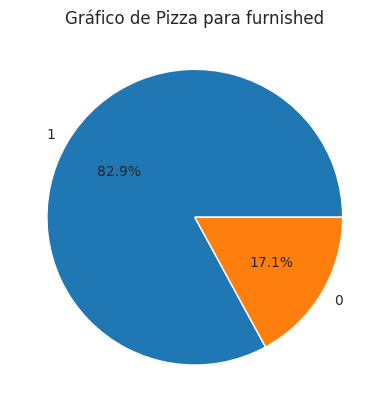

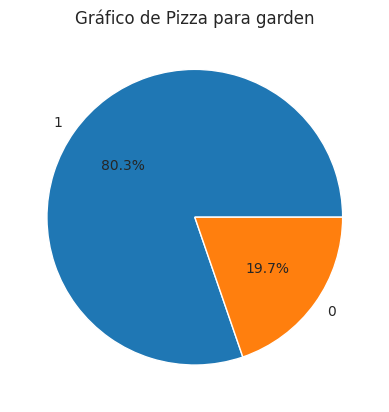

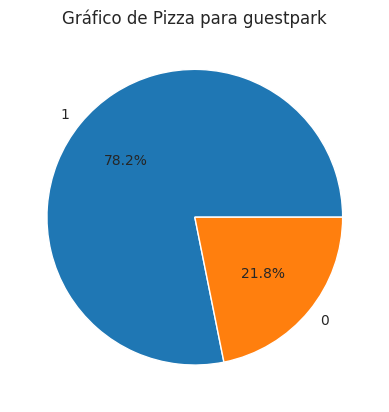

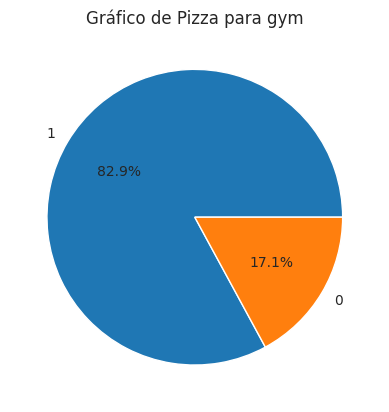

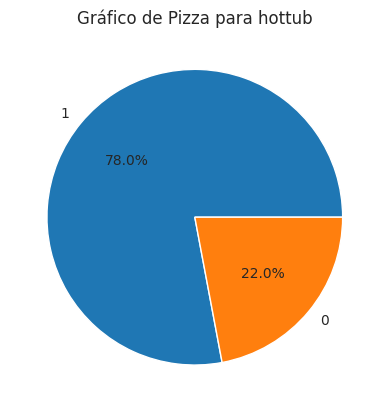

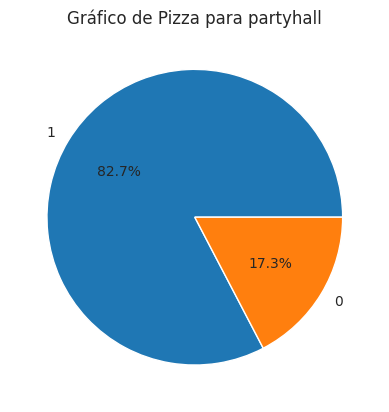

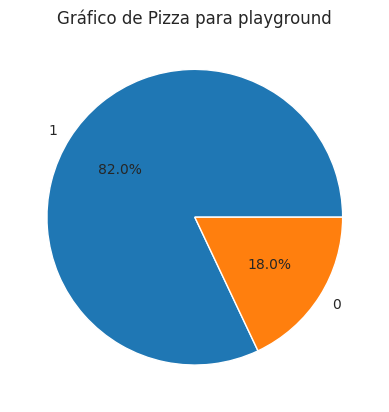

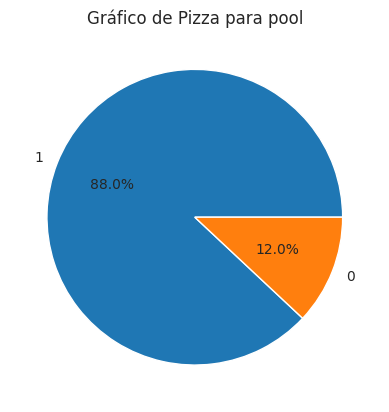

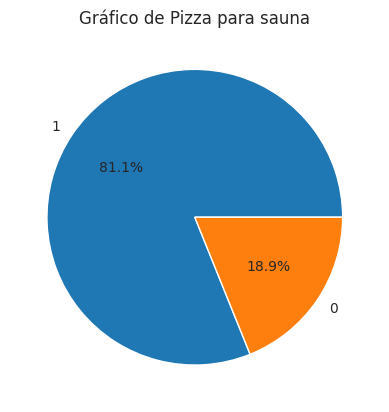

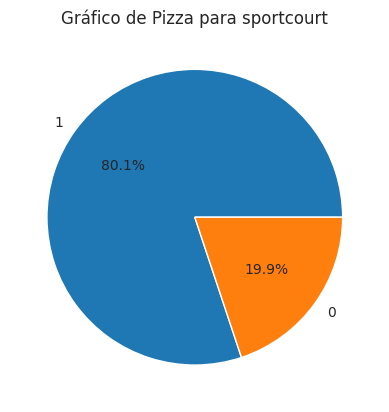

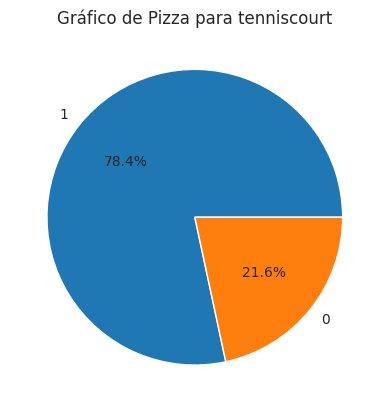

In [15]:
for coluna in colunas_categoricas_bool:
    plt.figure()
    df_filtrado[coluna].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title(f'Gráfico de Pizza para {coluna}')
    plt.ylabel('')
    plt.show()
    #print("Coluna:", coluna, "1 = ", df_filtrado[coluna].value_counts()[1]/df_filtrado.shape[0] \
    #    ,"0 = ", df_filtrado[coluna].value_counts()[0]/df_filtrado.shape[0])
    # print pode facilitar a visualização

Das variáveis analisadas, resolvi retirar as seguintes, mantendo apenas:

       backyard, garden, gym, hottub, sportcourt, tenniscourt

In [16]:
colunas_drop = ['barbgrill', 'fireplace', 'furnished', 'partyhall', 'pool',
                "guestpark", "playground",
                "sauna", "bathtub"]
                
df_ = df_filtrado.drop(colunas_drop, axis = 1)
df_.info(0)

<class 'pandas.core.frame.DataFrame'>
Index: 13611 entries, 0 to 16791
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   bathrooms        13611 non-null  int64 
 1   parkingSpaces    13611 non-null  int64 
 2   monthlyCondoFee  13611 non-null  int64 
 3   usableAreas      13611 non-null  int64 
 4   bedrooms         13611 non-null  int64 
 5   backyard         13611 non-null  int64 
 6   garden           13611 non-null  int64 
 7   gym              13611 non-null  int64 
 8   hottub           13611 non-null  int64 
 9   sportcourt       13611 non-null  int64 
 10  tenniscourt      13611 non-null  int64 
 11  imvl_type        13611 non-null  object
 12  address.region   13611 non-null  object
 13  salePrice        13611 non-null  object
dtypes: int64(11), object(3)
memory usage: 1.6+ MB


Entender um pouco das variáveis multicategóricas

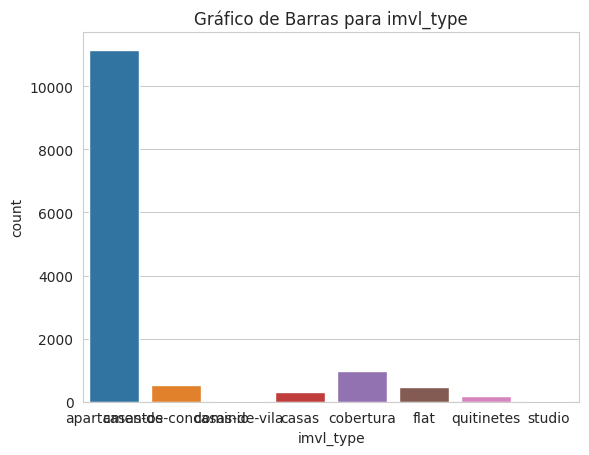

None

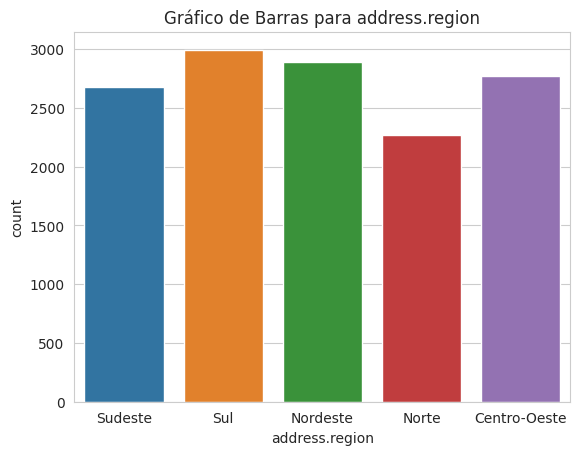

None

In [17]:
for coluna in colunas_multcategoricas:
    plt.figure()
    sns.countplot(data=df_, x=coluna)
    plt.title(f'Gráfico de Barras para {coluna}')
    display(plt.show())


A categoria imvl_type é totalmente dominada por apartamentos, mas vou mantê-la pois o tipo de ímovel pode determinar fortemente o valor dele, principalmente quando temos coberturas, por exemplo 

In [18]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13611 entries, 0 to 16791
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   bathrooms        13611 non-null  int64 
 1   parkingSpaces    13611 non-null  int64 
 2   monthlyCondoFee  13611 non-null  int64 
 3   usableAreas      13611 non-null  int64 
 4   bedrooms         13611 non-null  int64 
 5   backyard         13611 non-null  int64 
 6   garden           13611 non-null  int64 
 7   gym              13611 non-null  int64 
 8   hottub           13611 non-null  int64 
 9   sportcourt       13611 non-null  int64 
 10  tenniscourt      13611 non-null  int64 
 11  imvl_type        13611 non-null  object
 12  address.region   13611 non-null  object
 13  salePrice        13611 non-null  object
dtypes: int64(11), object(3)
memory usage: 1.6+ MB


## Preparação dos Dados para o Modelo

Aqui vou, além de separar em treino e teste aplicar o StandardScaler, um OneHotEncoder para as multicategóricas e um label encoder para o target.


In [19]:
X = df_.drop("salePrice", axis = 1)
y = df_["salePrice"]

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.3, random_state=42)

print(X_treino.shape[0], X_teste.shape[0])

9527 4084


In [20]:
scaler = StandardScaler()
X_treino[colunas_numericas] = scaler.fit_transform(X_treino[colunas_numericas])

X_teste[colunas_numericas] = scaler.transform(X_teste[colunas_numericas])

In [21]:
onehot =  OneHotEncoder(handle_unknown='ignore', sparse_output = False, categories = "auto", dtype='int8')

colunas_treino = pd.DataFrame(onehot.fit_transform(X_treino[colunas_multcategoricas]))
#colunas_validacao = pd.DataFrame(onehot.transform(X_validacao[colunas_multcategoricas]))
colunas_teste = pd.DataFrame(onehot.transform(X_teste[colunas_multcategoricas]))

columns = onehot.get_feature_names_out(colunas_multcategoricas)

colunas_treino.columns = columns
colunas_treino.index = X_treino.index

#colunas_validacao.columns = columns
#colunas_validacao.index = X_validacao.index

colunas_teste.columns = columns
colunas_teste.index = X_teste.index

X_treino_ = X_treino.drop(colunas_multcategoricas, axis=1)
#X_validacao_ = X_validacao.drop(colunas_multcategoricas, axis=1)
X_teste_ = X_teste.drop(colunas_multcategoricas, axis=1)

X_treino_ = pd.concat([X_treino_, colunas_treino], axis=1)
#X_validacao_ = pd.concat([X_validacao_, colunas_validacao], axis=1)
X_teste_ = pd.concat([X_teste_, colunas_teste], axis = 1)

In [22]:
lb = LabelEncoder()

y_treino_ = pd.DataFrame(lb.fit_transform(y_treino))
#y_validacao_ =  pd.DataFrame(lb.transform(y_validacao))
y_teste_ =  pd.DataFrame(lb.transform(y_teste))

## Treino do Modelo

A partir daqui não tem muito segredo, apenas vou treinar um GridSearch para Árvore de Decisão e um treino comum para regressão logística.

In [23]:
tree = DecisionTreeClassifier()

param_grid = {
    'max_depth': [None, 5, 10, 15, 20, 25],  # Profundidade máxima da árvore
    'min_samples_split': [2, 5, 10, 12, 16],  # Número mínimo de amostras necessárias para dividir um nó interno
    'min_samples_leaf': [2, 4, 8, 12],  # Número mínimo de amostras necessárias para ser uma folha
    'criterion': ['gini', 'entropy'] # Critério de separação
}

grid_search = GridSearchCV(tree, param_grid, cv=5)

y_treino__ = y_treino_.values.ravel()
y_teste__ = y_teste_.values.ravel()

grid_search.fit(X_treino_, y_treino__)

best_model = grid_search.best_estimator_

pred = best_model.predict(X_teste_)
print(accuracy_score(y_teste__, pred, normalize = True))

best_params = grid_search.best_params_
print("Melhores hiperparâmetros:", best_params)

0.7879529872673849
Melhores hiperparâmetros: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 12}


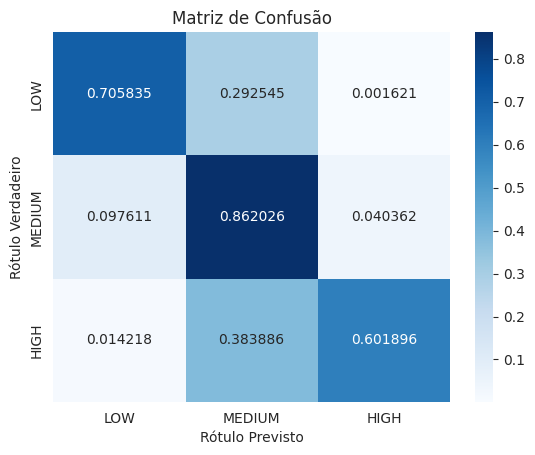

In [24]:
pred_inverse = lb.inverse_transform(pred)
y_teste_inverse = lb.inverse_transform(y_teste__)

cm = confusion_matrix(y_teste_inverse, pred_inverse, normalize = 'true', labels = ['LOW', 'MEDIUM', 'HIGH'])
classes = ['LOW', 'MEDIUM', 'HIGH']

sns.heatmap(cm, annot=True, fmt='f', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Configurar os rótulos dos eixos e o título

plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de Confusão')

# Mostrar o gráfico
plt.show()

In [25]:
lr = LogisticRegression(multi_class = "multinomial", solver = "lbfgs", max_iter = 300)

y_treino__ = y_treino_.values.ravel()
lr.fit(X_treino_, y_treino__)

y_teste__ = y_teste_.values.ravel()

pred = lr.predict(X_teste_)
print(accuracy_score(y_teste__, pred, normalize = True))

0.7698334965719883


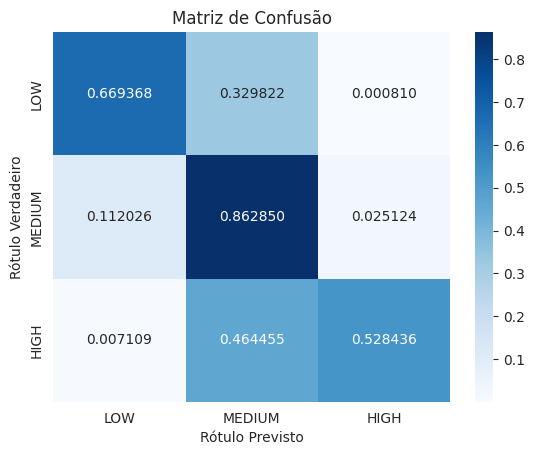

In [26]:
pred_inverse = lb.inverse_transform(pred)
y_teste_inverse = lb.inverse_transform(y_teste__)

cm = confusion_matrix(y_teste_inverse, pred_inverse, normalize = 'true', labels = ['LOW', 'MEDIUM', 'HIGH'])
classes = ['LOW', 'MEDIUM', 'HIGH']

sns.heatmap(cm, annot=True, fmt='f', cmap='Blues', xticklabels=classes, yticklabels=classes)

plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de Confusão')

# Mostrar o gráfico
plt.show()